In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer
from fancyimpute import SoftImpute
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import StackingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:

!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.3 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=2e5f2f9ab45080df13934e5b33f823a42b740d44227bd5282c1904e83070ab12
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=396461318763b1eb9bbf187b7516a182fd0a0656783de3a1c9fcaef5baaf0410
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
data=pd.read_csv('/content/online_retail_customer_churn.csv')

Streaming output truncated to the last 5000 lines.
[SoftImpute] Iter 100: observed MAE=47.332794 rank=3
[SoftImpute] Stopped after iteration 100 for lambda=3490.531527
[SoftImpute] Max Singular Value of X_init = 174526.576359
[SoftImpute] Iter 1: observed MAE=47.180488 rank=3
[SoftImpute] Iter 2: observed MAE=47.259515 rank=3
[SoftImpute] Iter 3: observed MAE=47.289456 rank=3
[SoftImpute] Iter 4: observed MAE=47.300716 rank=3
[SoftImpute] Iter 5: observed MAE=47.305549 rank=3
[SoftImpute] Iter 6: observed MAE=47.307950 rank=3
[SoftImpute] Iter 7: observed MAE=47.309397 rank=3
[SoftImpute] Iter 8: observed MAE=47.310416 rank=3
[SoftImpute] Iter 9: observed MAE=47.311227 rank=3
[SoftImpute] Iter 10: observed MAE=47.311933 rank=3
[SoftImpute] Iter 11: observed MAE=47.312580 rank=3
[SoftImpute] Iter 12: observed MAE=47.313189 rank=3
[SoftImpute] Iter 13: observed MAE=47.313772 rank=3
[SoftImpute] Iter 14: observed MAE=47.314334 rank=3
[SoftImpute] Iter 15: observed MAE=47.314878 rank=3
[So

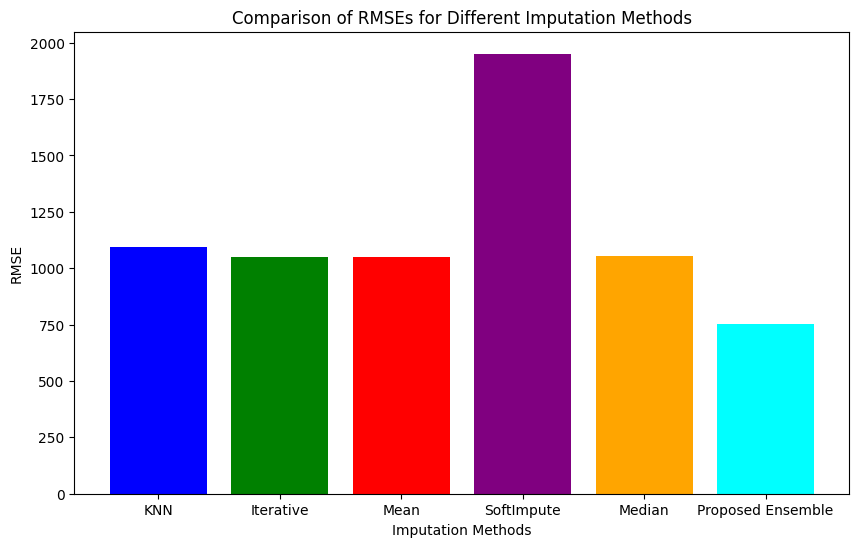

In [ ]:
data.drop(['Gender', 'Email_Opt_In', 'Promotion_Response', 'Target_Churn', 'Age'], axis=1, inplace=True)
data10A = data.copy()
# Select 10% of the rows
rows_to_modify = random.sample(range(len(data10A)), int(len(data10A) * 0.1))

columns_to_modify = range(1, 10)

# Set the selected values to NaN
for row_index in rows_to_modify:
    for column_index in columns_to_modify:
        data10A.iloc[row_index, column_index] = np.nan

null_values_count = data10A.isnull().sum()
print(null_values_count)

missing_positions = np.argwhere(pd.isnull(data10A).values)
# Initialize KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Initialize IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10)

# Initialize SimpleImputer with mean strategy
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize SoftImpute
soft_imputer = SoftImpute()

# Initialize SimpleImputer with median strategy
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

def calculate_rmse(imputed_data, original_data, missing_positions):
    missing_values = [(x, y) for x, y in missing_positions]
    original_values = [original_data.iloc[x, y] for x, y in missing_values]
    imputed_values = [imputed_data[x, y] for x, y in missing_values]
    return np.sqrt(mean_squared_error(original_values, imputed_values))

# Function to impute missing values using the proposed ensemble method
def ensemble_impute(data_with_missing, missing_positions, original_data):
    ip_temp = data_with_missing.copy()  # Ensure ip_temp is reset for each imputation
    imputed_data = data_with_missing.copy()
    for i in range(len(missing_positions)):
        x, y = missing_positions[i]

        # Impute using KNN
        ip_temp.iloc[x, y] = np.nan
        knn_imputed = knn_imputer.fit_transform(ip_temp)
        knn_value = knn_imputed[x, y]

        # Impute using Iterative Imputer
        ip_temp.iloc[x, y] = np.nan
        iterative_imputed = iterative_imputer.fit_transform(ip_temp)
        iterative_value = iterative_imputed[x, y]

        # Impute using Mean
        ip_temp.iloc[x, y] = np.nan
        mean_imputed = mean_imputer.fit_transform(ip_temp)
        mean_value = mean_imputed[x, y]

        # Impute using SoftImpute
        ip_temp.iloc[x, y] = np.nan
        soft_imputed = SoftImpute().fit_transform(ip_temp)
        soft_value = soft_imputed[x, y]

        # Impute using Median
        ip_temp.iloc[x, y] = np.nan
        median_imputed = median_imputer.fit_transform(ip_temp)
        median_value = median_imputed[x, y]

        # Store the imputed values in a dictionary
        imputed_values = {
            'knn': knn_value,
            'iterative': iterative_value,
            'mean': mean_value,
            'soft': soft_value,
            'median': median_value
        }
        original_value = original_data.iloc[x, y]
        rmses = {method: np.sqrt(mean_squared_error([value], [original_value])) for method, value in imputed_values.items()}

        # Select the method with the smallest RMSE
        best_method = min(rmses, key=rmses.get)

        # Impute the value at (x, y) in the original dataset using the best method
        imputed_data.iloc[x, y] = imputed_values[best_method]

    return imputed_data

ensemble_imputed = ensemble_impute(data10A, missing_positions, data)

knn_imputed = knn_imputer.fit_transform(data10A)

# Impute using Iterative Imputer
iterative_imputed = iterative_imputer.fit_transform(data10A)

# Impute using Mean
mean_imputed = mean_imputer.fit_transform(data10A)

# Impute using SoftImpute
soft_imputed = SoftImpute().fit_transform(data10A)

# Impute using Median
median_imputed = median_imputer.fit_transform(data10A)

# Calculate RMSE for each method
knn_rmse = calculate_rmse(knn_imputed, data, missing_positions)
iterative_rmse = calculate_rmse(iterative_imputed, data, missing_positions)
mean_rmse = calculate_rmse(mean_imputed, data, missing_positions)
soft_rmse = calculate_rmse(soft_imputed, data, missing_positions)
median_rmse = calculate_rmse(median_imputed, data, missing_positions)
ensemble_rmse = calculate_rmse(ensemble_imputed.values, data, missing_positions)

# Plot the RMSEs
methods = ['KNN', 'Iterative', 'Mean', 'SoftImpute', 'Median', 'Proposed Ensemble']
rmses = [knn_rmse, iterative_rmse, mean_rmse, soft_rmse, median_rmse, ensemble_rmse]

plt.figure(figsize=(10, 6))
plt.bar(methods, rmses, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.xlabel('Imputation Methods')
plt.ylabel('RMSE')
plt.title('Comparison of RMSEs for Different Imputation Methods')
plt.show()


